## Image Captioning with Conditioned LSTM Generators



Follow the instructions in this notebook step-by step. Much of the code is provided, but some sections are marked with **TODO**. 

Specifically, you will build the following components: 

* Create matrices of image representations using an off-the-shelf image encoder.
* Read and preprocess the image captions. 
* Write a generator function that returns one training instance (input/output sequence pair) at a time. 
* Train an LSTM language generator on the caption data.
* Write a decoder function for the language generator. 
* Add the image input to write an LSTM caption generator. 
* Beam search to refine output captions.

Each group please submit one copy of this notebook only, including all outputs. 

Reference:
https://medium.com/@raman.shinde15/image-captioning-with-flickr8k-dataset-bleu-4bcba0b52926#:~:text=Captions%20are%20read%20from%20Flickr8k.token.txt%20file%20and%20stored,format%20%E2%80%9Cstartseq%20%E2%80%9C%20%2B%20caption%20%2B%20%E2%80%9C%20endseq%E2%80%9D

### Getting Started 

First, run the following commands to make sure you have all required packages. 

In [ ]:
# tested with python 3.6
import os
from collections import defaultdict
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.activations import softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf


In [ ]:
load = True
tf.autograph.set_verbosity(1)
tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
if load:
  !cp /content/drive/MyDrive/flicker/* .

In [ ]:
prefix = './'

### Access to the flickr8k data

We will use the flickr8k data set, described here in more detail: 

> M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html

Dataset: https://www.kaggle.com/datasets/adityajn105/flickr8k

You need to download the dataset and then upload it again to your own drive. Please assign the name you choose for this folder to the variable `my_data_dir` in the next cell.


**To Download the datasets from kaggle**

In [ ]:
if 'Images' not in os.listdir():
  !mkdir ~/.kaggle

  !cp /content/kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download 'adityajn105/flickr8k'
  !unzip -qq flickr8k.zip
  !rm flickr8k.zip

In [ ]:
#this is where you put the name of your data folder.
#Please make sure it's correct because it'll be used in many places later.
my_data_dir="hw3_data"

### Mounting your GDrive so you can access the files from Colab (optional)

In [ ]:
#running this command will generate a message that will ask you to click on a link where you'll obtain your GDrive auth code.
#copy paste that code in the text box that will appear below
# drive.mount('/content/gdrive')

Please look at the 'Files' tab on the left side and make sure you can see the 'hw5_data' folder that you have in your GDrive.

## Part I: Understand the data (10 pts)

> Indented block



Read the caption file:

In [ ]:
df = pd.read_csv(f'{prefix}/captions.txt')
print(df.shape)
df.head()

(40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

Train, test split:

In [ ]:
# TODO: train, test split: 0.8: 0.2
if load:
  train_df = pd.read_csv(f'train.csv')
  test_df = pd.read_csv(f'test.csv')
else:
  train_df, test_df = train_test_split(df, test_size=0.2)
  train_df = train_df.reset_index(drop=True)
  test_df = test_df.reset_index(drop=True)
 

In [ ]:
train_df.to_csv(f'train.csv')
test_df.to_csv(f'test.csv')

Each entry is an image filename.

In [ ]:
train_df.head()

Unnamed: 0                      image  \
0           0  3169591322_d0b6d0cd04.jpg   
1           1  2687529141_edee32649e.jpg   
2           2   269898095_d00ac7d7a4.jpg   
3           3  1594038143_57f299aa8a.jpg   
4           4  3103264875_2a8d534abc.jpg   

                                             caption  
0  a skateboarder is airborne in front of some lo...  
1  Two men scantily clad performing acrobatic mov...  
2  A woman is sitting near a flower bed overlooki...  
3  A man in a pink shirt is showing a magic trick...  
4                A dog running with his tongue out .

Check an example:

**example of image captioning**


In [ ]:
example_file = train_df.iloc[9]['image']
cap = train_df.iloc[9]['caption']
image = Image.open(os.path.join(f'{prefix}/Images', example_file))
print(image.size)
print(cap)

(500, 375)
Three men in dress shirts in a bar , with a woman lying on the bar and a female bartender in the background .


If you can't see the image, try

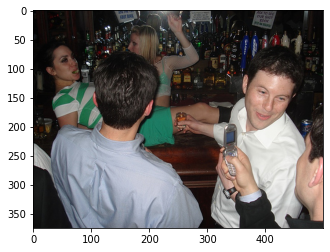

In [ ]:
plt.imshow(image)

## Part II: Image encoder (10 pts)
We are going to use an off-the-shelf pre-trained image encoder, the Inception V3 network. The model is a version of a convolution neural network for object detection. Here is more detail about this model (not required for this project): 

> Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
> https://www.cv-foundation.org/openaccess/content_cvpr_2016/html/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.html

The model requires that input images are presented as 299x299 pixels, with 3 color channels (RGB). The individual RGB values need to range between 0 and 1.0. The flickr images don't fit. 

In [ ]:
np.asarray(image).shape

(375, 500, 3)

The values range from 0 to 255. 

In [ ]:
np.asarray(image)

array([[[10,  4,  6],
        [ 7,  7,  7],
        [ 2,  8,  6],
        ...,
        [ 9,  9,  9],
        [ 8,  8,  8],
        [ 8,  8,  8]],

       [[ 7,  1,  3],
        [ 5,  5,  5],
        [ 4, 10,  8],
        ...,
        [10,  8,  9],
        [ 7,  7,  7],
        [ 6,  6,  6]],

       [[ 5,  0,  4],
        [ 6,  6,  8],
        [ 7, 13, 13],
        ...,
        [ 9,  7,  8],
        [ 7,  5,  6],
        [ 6,  6,  6]],

       ...,

       [[14, 14, 14],
        [14, 14, 14],
        [15, 15, 15],
        ...,
        [34, 36, 35],
        [35, 35, 35],
        [34, 34, 34]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [35, 37, 36],
        [36, 36, 36],
        [35, 35, 35]],

       [[16, 16, 16],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [36, 38, 37],
        [37, 37, 37],
        [36, 36, 36]]], dtype=uint8)

We can use PIL to resize the image and then divide every value by 255. 

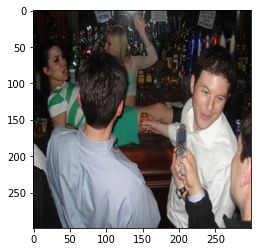

In [ ]:
new_image = np.asarray(image.resize((299,299))) / 255.0
plt.imshow(new_image)

In [ ]:
new_image.shape

(299, 299, 3)

Let's put this all in a function for convenience. 

**read_image()**


**It reads an image from the Images folder, resizes it to 299x299, and returns the image as a numpy array**


    
**:param image_name: The name of the image file**
**return: The image is being returned as an array of pixel values.**

In [ ]:
def read_image(image_name):
    image = Image.open(os.path.join(f'{prefix}/Images', image_name))
    return np.asarray(image.resize((299,299))) / 255.0                     

Next, we load the pre-trained Inception model. 

In [ ]:
img_model = InceptionV3(weights='imagenet') # This will download the weight files for you and might take a while.

In [ ]:
img_model.summary() # this is quite a complex model. 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

This is a prediction model,so the output is typically a softmax-activated vector representing 1000 possible object types. Because we are interested in an encoded representation of the image we are just going to use the second-to-last layer as a source of image encodings. Each image will be encoded as a vector of size 2048. 

We will use the following hack: hook up the input into a new Keras model and use the penultimate layer of the existing model as output.

In [ ]:
new_input = img_model.input
new_output = img_model.layers[-2].output
img_encoder = Model(new_input, new_output) # This is the final Keras image encoder model we will use.

Let's try the encoder. 

In [ ]:
encoded_image = img_encoder.predict(np.array([new_image]))

1/1 [==============================] - 2s 2s/step


In [ ]:
encoded_image.shape

(1, 2048)

**TODO:** We will need to create encodings for all images and store them in one big matrix (one for each dataset, train, test).
We can then save the matrices so that we never have to touch the bulky image data again. 

To save memory (but slow the process down a little bit) we will read in the images lazily using a generator. We will encounter generators again later when we train the LSTM. If you are unfamiliar with generators, take a look at this page: https://wiki.python.org/moin/Generators

Write the following generator function, which should return one image at a time. 
`img_list` is a list of image file names (i.e. the train, dev, or test set). The return value should be a numpy array of shape (1,299,299,3).

Now we can encode all images (this takes a few minutes).

**img_generator**


**It takes a list of image filenames and returns a generator that yields the images in the list**
    
**:param img_list: a list of image filenames**

In [ ]:
def img_generator(img_list):
    for filename in img_list:
        image = read_image(filename)
        yield image.reshape(1,299,299,3)

In [ ]:
train_list = train_df.image
test_list = test_df.image

In [ ]:
if load:
  enc_train = np.load("encoded_images_train.npy")
  enc_test = np.load("encoded_images_test.npy")
else:
  enc_train = img_encoder.predict(img_generator(train_list), steps=len(train_list), verbose=1)
  enc_test = img_encoder.predict(img_generator(test_list), steps=len(test_list), verbose=1)
  np.save(f"encoded_images_train.npy", enc_train)
  np.save(f"encoded_images_test.npy", enc_test)

In [ ]:
enc_train.shape

(32364, 2048)

It's a good idea to save the resulting matrices, so we do not have to run the encoder again. 

In [ ]:
if 'Flickr8k.token.txt' not in os.listdir():
  !wget https://raw.githubusercontent.com/text-machine-lab/MUTT/master/data/flickr/Flickr8k.token.txt

## Part III Text (Caption) Data Preparation (10 pts)

Next, we need to load the image captions and generate training data for the generator model.

### Reading image descriptions

**TODO**: Write the following function that reads the image descriptions from the file `filename` and returns a dictionary in the following format. Take a look at the file `Flickr8k.token.txt` for the format of the input file. Data from https://github.com/text-machine-lab/MUTT/tree/master/data/flickr

The keys of the dictionary should be image filenames. Each value should be a list of 5 captions. Each caption should be a list of tokens.  

The captions in the file are already tokenized, so you can just split them at white spaces. You should convert each token to lower case. You should then pad each caption with a START token on the left and an END token on the right. 

**process_line**


**It takes a line of text, splits it into a key and a value, tokenizes the value, and returns the keyand the tokenized value :param line: the line of text to process**


**:return: The key and the tokens**


**read_image_descriptions()**

**Read the file line by line, and for each line, call the `process_line` function to get the image id and the list of tokens Store the list of tokens in a dictionary, with the image id as the key**. 

** Return the dictionary**. 
    
   **Let's see how this works**.
    
  **:param filename:**
**The file containing the image descriptions**

**:return: A dictionary with the image name as the key and a list of tokens as the value.**



In [ ]:
import re

non_alpha = re.compile('[^a-zA-Z\s+]')
# spaces = re.compile('\s+')

def process_line(line):
    key, res = line.split("\t", 1)
    tokens = [non_alpha.sub('', token) for token in res.lower().split(" ")]
    tokens = ['<START>'] + [token for token in tokens if token.strip()] + ['<END>']
    return key.split('#')[0], tokens


def read_image_descriptions(filename):    
    image_descriptions = defaultdict(list)
    with open(filename, 'r') as f:
        for line in f.readlines():
            key, tokens = process_line(line.strip())
            image_descriptions[key].append(tokens)
    return image_descriptions

In [ ]:
# Populating description dictionary using the above method
descriptions = read_image_descriptions(f"Flickr8k.token.txt")

In [ ]:
print(descriptions[train_list.iloc[0]])

[['<START>', 'a', 'man', 'performs', 'a', 'skateboard', 'trick', 'in', 'a', 'parking', 'lot', '<END>'], ['<START>', 'a', 'person', 'on', 'a', 'skateboard', 'during', 'a', 'high', 'jump', '<END>'], ['<START>', 'a', 'skateboarder', 'is', 'airborne', 'in', 'front', 'of', 'some', 'low', 'brick', 'buildings', '<END>'], ['<START>', 'a', 'skateboarder', 'is', 'flying', 'through', 'the', 'air', 'on', 'a', 'red', 'skateboard', '<END>'], ['<START>', 'a', 'skateboarding', 'soaring', 'through', 'the', 'air', 'in', 'front', 'of', 'a', 'blue', 'building', '<END>']]


Running the previous cell should print similar to this:     
`[['<START>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '.', '<END>'], ['<START>', 'a', 'girl', 'going', 'into', 'a', 'wooden', 'building', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'climbing', 'the', 'stairs', 'to', 'her', 'playhouse', '.', '<END>'], ['<START>', 'a', 'little', 'girl', 'in', 'a', 'pink', 'dress', 'going', 'into', 'a', 'wooden', 'cabin', '.', '<END>']]
`    

### Creating Word Indices

Next, we need to create a lookup table from the **training** data mapping words to integer indices, so we can encode input 
and output sequences using numeric representations. **TODO** create the dictionaries id_to_word and word_to_id, which should map tokens to numeric ids and numeric ids to tokens.  
Hint: Create a set of tokens in the training data first, then convert the set into a list and sort it. This way if you run the code multiple times, you will always get the same dictionaries. 

**flatten()**


**It takes a list of lists and returns a list of all the elements in the sublists:param l: the list to flatten :return: A list of all the elements in the list l**

**get_flat_token_list()**


**It takes a dictionary of descriptions and returns a list of all the tokens in the descriptions :param descriptions: a dictionary of the form {filename: [list of descriptions]} :return: A list of all the tokens in the descriptions**


**get_word_indices()**

**Given a list of tokens, return a dictionary mapping each token to a unique integer, and a dictionary mapping each integer to a unique token.:param token_list: a list of all the tokens in the descriptions**


**:return: A dictionary of words to indices and a dictionary of indices to words**










In [ ]:
# TODO: 
# Creating the unique words list, using the set and list sort method
import itertools

def flatten(l):
    return itertools.chain.from_iterable(l)


def get_flat_token_list(descriptions):
    token_list = []
    for filename in train_list:
        token_list += list(flatten(descriptions[filename]))
    return token_list

def get_word_indices(token_list):
    unique_tokens = set(token_list)
    sorted_list = sorted(list(unique_tokens))
    word_to_id = {token: i for i, token in enumerate(sorted_list)}
    id_to_word = {i: token for i, token in enumerate(sorted_list)}
    return word_to_id, id_to_word
token_list = get_flat_token_list(descriptions)
word_to_id, id_to_word = get_word_indices(token_list)

In [ ]:
token_list = get_flat_token_list(descriptions)
word_to_id, id_to_word = get_word_indices(token_list)

In [ ]:
word_to_id['dog'] # should print an integer

2224

In [ ]:
id_to_word[1985] # should print a token

'dance'

In [ ]:
max_word_length = max([len(i) for i in id_to_word.values()])
max_word_length

19

In [ ]:
len(word_to_id)

8779

In [ ]:
len(id_to_word)

8779

Note that we do not need an UNK word token because we are generating. The generated text will only contain tokens seen at training time.  

## Part IV Basic Decoder Model (20 pts)

For now, we will just train a model for text generation without conditioning the generator on the image input. 

There are different ways to do this and our approach will be slightly different from the generator discussed in class. 

The core idea here is that the Keras recurrent layers (including LSTM) create an "unrolled" RNN. Each time-step is represented as a different unit, but the weights for these units are shared. We are going to use the constant MAX_LEN to refer to the maximum length of a sequence, which turns out to be 40 words in this data set (including START and END).

In [ ]:
max(len(description) for image_id in train_list for description in descriptions[image_id])

37

In class, we discussed LSTM generators as transducers that map each word in the input sequence to the next word. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm1.png" width="480px">

Instead, we will use the model to predict one word at a time, given a partial sequence. For example, given the sequence ["START","a"], the model might predict "dog" as the most likely word. We are basically using the LSTM to encode the input sequence up to this point. 
<img src="http://www.cs.columbia.edu/~bauer/4705/lstm2.png" width="480px">


To train the model, we will convert each description into a set of input output pairs as follows. For example, consider the sequence 

`['<START>', 'a', 'black', 'dog', '.', '<END>']`

We would train the model using the following input/output pairs 

| i | input                        | output |
|---|------------------------------|--------|
| 0 |[`START`]                     | `a`    |  
| 1 |[`START`,`a`]                 | `black`|
| 2 |[`START`,`a`, `black`]        | `dog`  |
| 3 |[`START`,`a`, `black`, `dog`] | `END`  |



Here is the model in Keras Keras. Note that we are using a Bidirectional LSTM, which encodes the sequence from both directions and then predicts the output. 
Also note the `return_sequence=False` parameter, which causes the LSTM to return a single output instead of one output per state. 

$$p(x) = \Pi_1^{n}p(x_i | x_1, ..., x_{i-1}, img)$$

Note also that we use an embedding layer for the input words. The weights are shared between all units of the unrolled LSTM. We will train these embeddings with the model. 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
vocab_size = len(word_to_id)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Bidirectional(LSTM(512, return_sequences=False))(embedding)
pred = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=[text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 40, 300)           2633700   
                                                                 
 bidirectional_2 (Bidirectio  (None, 1024)             3330048   
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 8779)              8998475   
                                                                 
Total params: 14,962,223
Trainable params: 14,962,223
Non-trainable params: 0
_________________________________________________________________


The model input is a numpy ndarray (a tensor) of size `(batch_size, MAX_LEN)`. Each row is a vector of size MAX_LEN in which each entry is an integer representing a word (according to the `word_to_id` dictionary). If the input sequence is shorter than MAX_LEN, the remaining entries should be padded with 0. 

For each input example, the model returns a softmax activated vector (a probability distribution) over possible output words. The model output is a numpy ndarray of size `(batch_size, vocab_size)`. vocab_size is the number of vocabulary words. 

### Creating a Generator for the Training Data

**TODO**: 

We could simply create one large numpy ndarray for all the training data. Because we have a lot of training instances (each training sentence will produce up to MAX_LEN input/output pairs, one for each word), it is better to produce the training examples *lazily*, i.e. in batches using a generator (recall the image generator in part I). 

Write the function `text_training_generator` below, that takes as a paramater the batch_size and returns an `(input, output)` pair. `input` is a `(batch_size, MAX_LEN)` ndarray of partial input sequences, `output` contains the next words predicted for each partial input sequence, encoded as a `(batch_size, vocab_size)` ndarray.

Each time the next() function is called on the generator instance, it should return a new batch of the *training* data. You can use `train_list` as a list of training images. A batch may contain input/output examples extracted from different descriptions or even from different images. 

You can just refer back to the variables you have defined above, including `descriptions`, `train_list`, `vocab_size`, etc. 


Hint: To prevent issues with having to reset the generator for each epoch and to make sure the generator can always return exactly `batch_size` input/output pairs in each step, wrap your code into a `while True:` loop. This way, when you reach the end of the training data, you will just continue adding training data from the beginning into the batch. 

**tokenize()**

**It takes a list of words and returns a list of their corresponding ids :param word_list: list of words :return: the word_to_id dictionary**


**detokenize()**


**It takes a list of token ids and returns a string of words :param token_list: a list of tokens, where each token is an integer**


**:return: the sentence that is being generated**





In [ ]:
def tokenize(word_list):
    return np.array([word_to_id[i] for i in word_list])

def detokenize(token_list):
  return " ".join([id_to_word[id] for id in token_list[1:] if id])


**init_batch()**



**It initializes the input_texts, output, and images arrays to be all zeros :param batch_size: The number of samples in a batch**


**training_generator()**


**For each image in the training set, we iterate over all the captions for that image, and for each caption, we iterate over all the tokens in that caption, and for each token, we create a training**


**example**
    
**:param batch_size: The number of samples per batch :param train_images: If True, the generator will return the image embeddings as well as the text, defaults to True (optional)**



**text_training_generator()**



**It takes a batch size, and returns a generator that yields batches of image/text pairs :param batch_size: The number of images to yield from the generator per batch, defaults to 128 (optional) :return: A generator that yields batches of training data**





In [ ]:
end_token = word_to_id['<END>']


def init_batch(batch_size):
  input_texts = np.zeros((batch_size, MAX_LEN))
  output = np.zeros((batch_size, vocab_size))
  images =  np.zeros((batch_size, 2048))
  rows = 0
  return input_texts, output, images, rows

def training_generator(batch_size, train_images=True):
  input_texts, output, images, rows = init_batch(batch_size)

  while True:
    for idx, filename in enumerate(train_list):
      tokens = tokenized[filename]
      for seq in tokens:
        for i, token in enumerate(seq):
          if token == end_token:
            continue
          input_texts[rows] = pad_sequences([seq[:i+1]], maxlen=MAX_LEN)[0]
          output[rows][seq[i+1]] = 1
          if train_images: images[rows] = enc_train[idx]
          rows += 1
          if rows == batch_size:
            if train_images: yield [images, input_texts], output
            else: yield input_texts, output
            input_texts, output, images, rows = init_batch(batch_size)

def text_training_generator(batch_size=128):
    return training_generator(batch_size, train_images=False)


### Training the Model

We will use the `fit_generator` method of the model to train the model. fit_generator needs to know how many iterator steps there are per epoch.

Because there are len(train_list) training samples with up to `MAX_LEN` words, an upper bound for the number of total training instances is `len(train_list)*MAX_LEN`. Because the generator returns these in batches, the number of steps is len(train_list) * MAX_LEN // batch_size

In [ ]:
batch_size = 128
generator = text_training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size 

**Training The model**

**Achive 42% accuraccy**

In [ ]:
if load:
  model.load_weights('text.h5')
else:
  checkpoint_path = f'/content/drive/MyDrive/flicker/text.ckpt'
  checkpoint_dir = os.path.dirname(checkpoint_path)

  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)

  model.fit(generator, steps_per_epoch=steps, epochs=10, callbacks=[cp_callback])
  model.save_weights("/content/drive/MyDrive/flicker/text.h5")

Epoch 1/10
10112/10113 [============================>.] - ETA: 0s - loss: 3.6996 - accuracy: 0.3763
Epoch 1: saving model to /content/drive/MyDrive/flicker/text.ckpt
10113/10113 [==============================] - 467s 46ms/step - loss: 3.6995 - accuracy: 0.3763
Epoch 2/10
10113/10113 [==============================] - ETA: 0s - loss: 3.7097 - accuracy: 0.4259
Epoch 2: saving model to /content/drive/MyDrive/flicker/text.ckpt
10113/10113 [==============================] - 463s 46ms/step - loss: 3.7097 - accuracy: 0.4259
Epoch 3/10
10113/10113 [==============================] - ETA: 0s - loss: 3.9601 - accuracy: 0.4282
Epoch 3: saving model to /content/drive/MyDrive/flicker/text.ckpt
10113/10113 [==============================] - 463s 46ms/step - loss: 3.9601 - accuracy: 0.4282
Epoch 4/10
10113/10113 [==============================] - ETA: 0s - loss: 3.9365 - accuracy: 0.4366
Epoch 4: saving model to /content/drive/MyDrive/flicker/text.ckpt
10113/10113 [==============================] - 4

Continue to train the model until you reach an accuracy of at least 40%. 

### Greedy Decoder

**TODO** Next, you will write a decoder. The decoder should start with the sequence `["<START>"]`, use the model to predict the most likely word, append the word to the sequence and then continue until `"<END>"` is predicted or the sequence reaches `MAX_LEN` words. 

**get_predictio()**




**Given a decoder function, get the prediction from the model:param decoder: a function that takes in a list of probabilities and returns the index of the most likely word**




   **return: A list of tokens**




In [ ]:
def get_prediction(decoder):
    arr = np.zeros(MAX_LEN).reshape(-1, MAX_LEN)
    idx = 0
    arr[0][idx] = start_id
    while idx < MAX_LEN - 1 :
        predictions = model.predict(arr, verbose=False)[0].astype(np.float64)
        pred = decoder(predictions)
        arr[0][idx] = pred
        if pred == end_id:
            break
        idx += 1
    output_list = detokenize(arr[0])
    return output_list

**argmax**



**It returns the index of the largest value in the list :param predictions: a list of probabilities for each class :return: The index of the highest value in the array**


**decoder()**

**It takes the argmax of the output of the decoder, and then feeds that as an input to the decoder to get the next word :return: The decoder function is returning the get_prediction function with the argmax function as the argument**





In [ ]:

end_id = word_to_id["<END>"]
start_id = word_to_id["<START>"]

def argmax(predictions):
    return predictions.argmax()

def decoder():
    return get_prediction(argmax)


In [ ]:
print(decoder())

for for towards towards towards towards towards towards towards towards towards towards towards beside beside front front baby front mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth little older older older older


This simple decoder will of course always predict the same sequence (and it's not necessarily a good one). 

Modify the decoder as follows. Instead of choosing the most likely word in each step, sample the next word from the distribution (i.e. the softmax activated output) returned by the model. Take a look at the [np.random.multinomial](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multinomial.html) function to do this. 

**multinomial()**



**It takes a vector of probabilities and returns a random index sampled from that vector :param predictions: the output of the model, a vector of probabilities for each class :return: The index of the most likely word**


**sample_decoder()**



**It takes a multinomial distribution and samples from it :return: The function get_prediction is being returned**

In [ ]:
def multinomial(predictions):
    predictions /= predictions.sum()
    freq = np.random.multinomial(10, predictions)
    return np.array(np.where(predictions == predictions[freq.argmax()])).flatten()[0]

def sample_decoder():
    return get_prediction(multinomial)





You should now be able to see some interesting output that looks a lot like flickr8k image captions -- only that the captions are generated randomly without any image input. 

In [ ]:
for i in range(10): 
    print(sample_decoder())

beside across by toward towards towards beside toward beside beside beside beside beside beside beside suit front mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth older older older little catch catch older older
beside for beside toward beside towards towards beside beside beside beside beside beside beside beside beside front front mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth catch mouth older older older catch older older
for beside towards towards towards towards towards towards towards towards towards towards towards towards beside front front front mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth catch catch catch catch older older older
for beside beside towards towards towards towards towards towards towards beside towards beside beside beside front front front mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth mouth older baby catch catch catch older older
beside into for t

## Part V - Conditioning on the Image (20 pts)

We will now extend the model to condition the next word not only on the partial sequence, but also on the encoded image. 

We will project the 2048-dimensional image encoding to a 300-dimensional hidden layer. 
We then concatenate this vector with each embedded input word, before applying the LSTM.

Here is what the Keras model looks like: 

In [ ]:
MAX_LEN = 40
EMBEDDING_DIM=300
IMAGE_ENC_DIM=300

# Image input
img_input = Input(shape=(2048,))
img_enc = Dense(300, activation="relu") (img_input)
images = RepeatVector(MAX_LEN)(img_enc)

# Text input
text_input = Input(shape=(MAX_LEN,))
embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
x = Concatenate()([images,embedding])
y = Bidirectional(LSTM(256, return_sequences=False))(x) 
pred = Dense(vocab_size, activation='softmax')(y)
model = Model(inputs=[img_input,text_input],outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer="RMSProp", metrics=['accuracy'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 300)          614700      ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 40, 300)     0           ['dense_4[0][0]']                
                                                                                            

The model now takes two inputs: 
    
   1. a `(batch_size, 2048)` ndarray of image encodings. 
   2. a `(batch_size, MAX_LEN)` ndarray of partial input sequences. 
    
And one output as before: a `(batch_size, vocab_size)` ndarray of predicted word distributions.   

**TODO**: Modify the training data generator to include the image with each input/output pair. 
Your generator needs to return an object of the following format: `([image_inputs, text_inputs], next_words)`. Where each element is an ndarray of the type described above.  

You need to find the image encoding that belongs to each image. You can use the fact that the index of the image in `train_list` is the same as the index in enc_train and enc_dev. 

If you have previously saved the image encodings, you can load them from disk: 

In [ ]:
enc_train = np.load("encoded_images_train.npy")

In [ ]:
enc_train[0].shape

(2048,)

***tokenize()***




**It takes a list of words and returns a list of integers corresponding to the words :param word_list: list of words in the vocabulary :return: A dictionary with the filename as the key and a list of lists of integers as the value**

In [ ]:
def tokenize(word_list):
    return [word_to_id[i] for i in word_list]

tokenized = defaultdict(list)
for filename in train_list:
  tokens = descriptions.get(filename)
  for words in tokens:
    tokenized[filename].append(tokenize(words))

You should now be able to train the model as before: 

In [ ]:
batch_size = 256
generator = training_generator(batch_size)
steps = len(train_list) * MAX_LEN // batch_size        

In [ ]:
tf.autograph.set_verbosity(1)
tf.get_logger().setLevel('ERROR')

checkpoint_path = f'cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
if load:
    model.load_weights("model.h5")
else:
    model.fit(generator, steps_per_epoch=steps, epochs=10, callbacks=[cp_callback])
    model.save_weights("/content/drive/MyDrive/flicker/model.h5")

Again, continue to train the model until you hit an accuracy of about 40%. This may take a while. I strongly encourage you to experiment with cloud GPUs using the GCP voucher for the class. 

You can save your model weights to disk and continue at a later time. 

to load the model: 

**TODO**: Now we are ready to actually generate image captions using the trained model. Modify the simple greedy decoder you wrote for the text-only generator, so that it takes an encoded image (a vector of length 2048) as input, and returns a sequence.

***The image_decoder()***

**We take the encoded image, feed it to the model along with a sequence of tokens, and get a probability distribution over the next token. We sample from this distribution and add the sampled token to the sequence. We repeat this process until we get the end token :param enc_image: The encoded image :return: the caption of the image**

In [ ]:
# input is enc_image, seq
start_id = word_to_id['<START>']
def image_decoder(enc_image):
    idx = 0
    
    seq = [start_id]
    while idx < MAX_LEN - 1 :
        padded = pad_sequences([seq], maxlen=40)
        predictions = model.predict([enc_image, padded], verbose=False)[0].astype(np.float64)
        pred = multinomial(predictions)
        seq.append(pred)
        if pred == end_id:
            break
            
        idx += 1
    return detokenize(seq)

'a man in a black jacket is holding a in for a child in a red jacket'

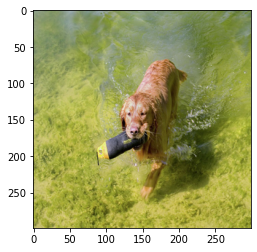

In [ ]:
# Training image test-1
idx = 10
t = np.array(enc_train[idx]).reshape(1,2048)
plt.imshow(read_image(train_list.iloc[idx]))
image_decoder(t)

You should also be able to apply the model to dev images and get reasonable captions:

(1, 2048)


'a person in a black jacket is holding a large sign that is near a that is on from a rope'

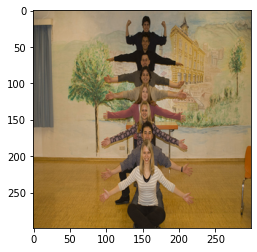

In [ ]:
# Testing dev image 1a
idx = 26
t = np.array(enc_test[idx]).reshape(1,2048)
plt.imshow(read_image(test_list[idx]))
print(t.shape)
image_decoder(t)

## Part VII Beam search (10 pts)

**TODO**: Use beam search algorithm to refine the output captions.

Reference: https://keras.io/api/keras_nlp/utils/beam_search/

https://keras.io/examples/nlp/text_generation_gpt/

**The beam_search()**



**function takes an image and returns a caption :param image: the image to caption :return: A list of strings**

**The pad() fuction takes a list of integers, and returns a list of lists of integers, where each list is padded to the same length :param t: the tokenized text :return: A padded sequence of the input text**

**It takes an image and returns a function that takes a list of tokens and returns the logits for the next token :param image: the image to be captioned :return: A function that takes in a list of integers and returns a list of floats**

In [ ]:

try:
    import keras_nlp
except ModuleNotFoundError:
    !pip install keras_nlp >> /dev/null
    import keras_nlp


prompt_tokens = tf.convert_to_tensor([tokenize(["<START>"])])


def pad(t):
  return pad_sequences([t], maxlen=MAX_LEN)

def token_logits_fn(image):
    def func(inputs):
        cur_len = inputs.shape[1]
        padded = pad(list(inputs.numpy()[0]))
        output = model.predict([image, padded], verbose=False)
        return output
    return func

def beam_search(image):
  logits_fn = token_logits_fn(image)
  output_tokens = keras_nlp.utils.beam_search(
      logits_fn,
      prompt_tokens,
      max_length=MAX_LEN,
      num_beams=10,
      from_logits=False,
  )
  return detokenize(output_tokens.numpy())




**TODO**: Randomly plot 10 images with captions from train set and test set each.

**plot_images()**





**this function plots 10 images from the test set, and for each image, it generates a caption using beam search**.
    
**:param file_list: a list of image file names**
**:param images: the list of images**

In [ ]:
from random import choice
def plot_images(file_list, images):
  for i in range(10):
    idx = choice(range(1000))
    t = np.array(images[idx]).reshape(1,2048)
    caption = beam_search(t)
    plt.figure()
    plt.imshow(read_image(test_list.iloc[idx]))
    plt.show()

**output**

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

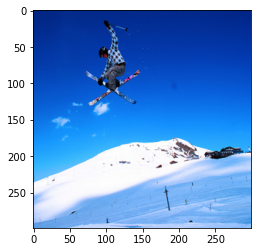

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

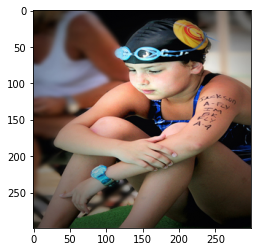

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 5457]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 6830]], shape=(1, 3), dtype=int32)
tf.T

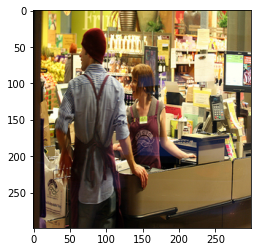

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 5457]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.T

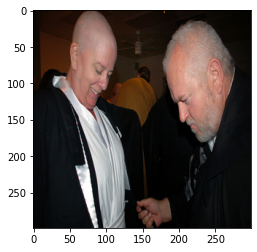

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

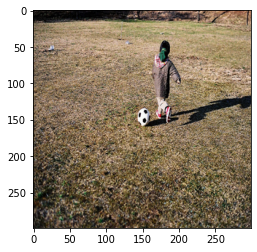

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

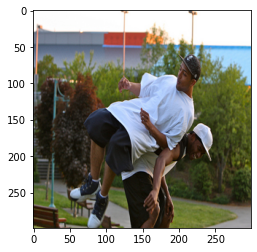

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 905]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Ten

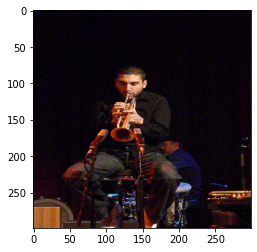

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

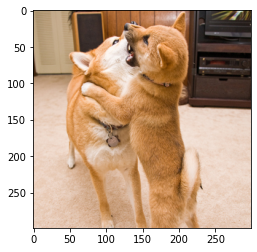

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Ten

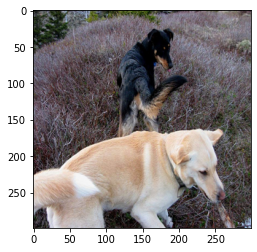

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Ten

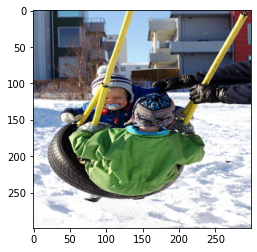

In [ ]:
plot_images(train_list, enc_train)

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Ten

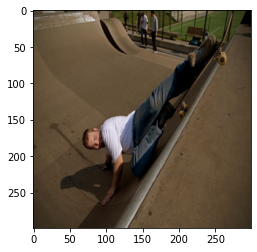

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.

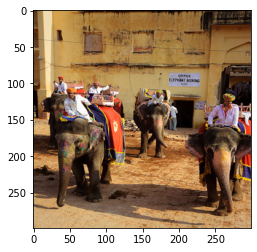

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 5457]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1 7789 5457]], shape=(1, 3), dtype=int32)
tf.T

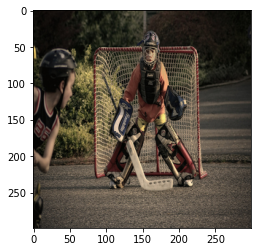

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

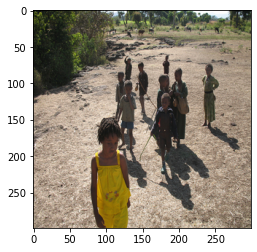

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 5457]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6830]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1 7789 5457]], shape=(1, 3), dtype=int32)
tf.T

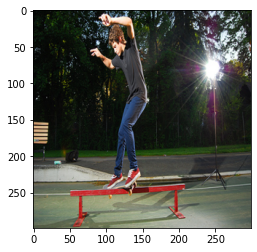

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

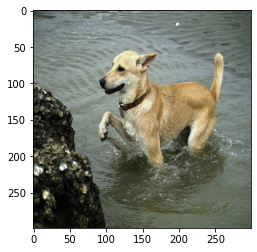

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 6601]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

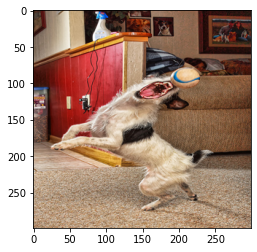

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 5457]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3918]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4773]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7078]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 193]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1 7789 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4383]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4751]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4760]], shape=(1, 3), dtype=int32)
t

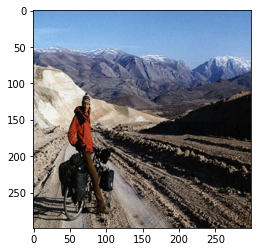

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 905]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 4347]], shape=(1, 3), dtype=int32)
tf.Ten

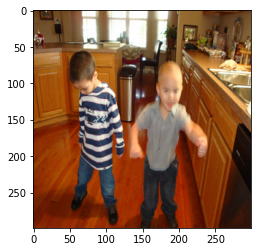

tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1]], shape=(1, 1), dtype=int32)
tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7789]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8152]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7827]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 188]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 7798]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 8750]], shape=(1, 2), dtype=int32)
tf.Tensor([[  1 729]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 4479]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1 3826]], shape=(1, 2), dtype=int32)
tf.Tensor([[   1    2 4479]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3380]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 3190]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 8750]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 5457]], shape=(1, 3), dtype=int32)
tf.Tensor([[   1    2 2224]], shape=(1, 3), dtype=int32)
tf.Tensor([[  1   2 905]], shape=(1, 3), dtype=int32)
tf.Ten

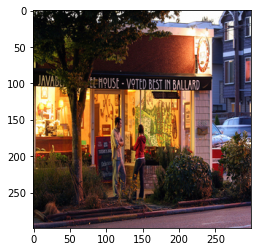

In [ ]:
plot_images(test_list, enc_test)
